# Linear Mixed Models II: LMMs with Categorical Predictors


**Important (if you didn't do this before trying out `01_lmms`)**:  
Before running this notebook open a terminal, activate the 201b environment, and update the `pymer4` package:

1. Open terminal
2. `conda activate 201b`
3. `pip install git+https://github.com/ejolly/pymer4.git --no-deps`

## Learning Goals & Resources

In the previous notebook we got a general introduction to Linear Mixed Models (LMMs) and met the `pymer4` library. In this notebook we'll build upon that foundation and focus on:

- Exploring the challenge solution from `01_lmms`
- How to decide your random-effect structure
- Interpreting model output
- LMMs with categorical predictor (2 levels)
- LMMs with categorical predictor (3 levels)
- Post-hoc tests of categorical predictors

### Slides for reference

[Linear Mixed Models I (slides from 03-10)](https://stat-intuitions.com/lectures/wk10/1.html)  

### Excellent Resources

We've compiled a list of excellent resources to better help you understand LMMs and posted it to the course website at this URL: https://tinyurl.com/lmm-resources

## Review

Let's begin by reviewing the interactive visual explainer from yesterday:

http://mfviz.com/hierarchical-models/

In [1]:
# Import some libraries we typically use
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
from polars import col
sns.set_context('notebook')
df = pl.read_csv('data/sleep.csv')

## How do I decide what my random effects are? (solution from `01_lmms`)

Let's review the challenge question from the end of the previous notebook. What this question is really getting after is helping you think about **how to decide what random effects to use**.

This is a **different** question than *what effects are significant* and should be the first step in your LMM model-building process.
What we're after is understanding:
- How much variability is there amongst my repeated measurements?
- Does taking this variability into account fit the data better?

We're going to take the approach we learned about in class: **use the Maximal random-effects structure supported by your design and data**

Let's start by building 3 models with 3 different random-effect structures from the end of the previous notebook and using model comparison:
1. **Random intercepts only**: accounts for baseline `Reaction` differences amongst `Subject`s 
2. **Random slopes only**: accounts for differences in the effect of `Days` amongst `Subject`s
3. **Random intercepts + slopes**: accounts for both baseline differences and effect differences (**maximal model**)

As a reminder here's the data:

| Variable   | Description                     |
|------------|---------------------------------|
| Subject     | Unique Subject ID              |
| Days      | Number of Days of sleep deprivation   |
| Reaction     | Subject's Reaction time in ms |

In [2]:
from pymer4.models import Lmer

# Random intercepts
model_i = Lmer('Reaction ~ Days + (1 | Subject)', data=df.to_pandas())
model_i.fit()

# Random slopes
model_s = Lmer('Reaction ~ Days + (0 + Days | Subject)', data=df.to_pandas())
model_s.fit()

# Random intercepts + slopes (correlated)
model_is = Lmer('Reaction ~ Days + (1 + Days | Subject)', data=df.to_pandas())
model_is.fit()

### Model comparison

To compare these models we can use the `lrt()` function which calculates a likelihood-ratio test between models  
This allows us to ask the same question we've been asking when we compared `ols()` models using `anova_lm()`:

*Do the additional model parameters result in a meaningful reduction in error (or improvement in fit)?*

The output below shows us that there isn't much difference between using *only* random intercepts or *only* random slopes. But the addition of *both* random intercepts *and* random slopes is worth it! In this case we're going to stick with our **maximal model**

In [3]:
from pymer4.stats import lrt

lrt(model_i, model_s, model_is)

refitting model(s) with ML (instead of REML)


model  npar          AIC          BIC  \
0       Reaction~Days+(1|Subject)     4  1802.078643  1814.850470   
1  Reaction~Days+(0+Days|Subject)     4  1782.080315  1794.852143   
2  Reaction~Days+(1+Days|Subject)     6  1763.939344  1783.097086   

   log-likelihood     deviance      Chisq   Df     P-val  Sig  
0     -897.039322  1794.078643                                 
1     -887.040158  1774.080315  19.998328  0.0                 
2     -875.969672  1751.939344  22.140971  2.0  0.000016  ***

### Examine estimated variance across clusters

Let's take a look at the estimated random-effects variance for our maximal model. We can do this by using the `.ranef_var` attribute of our model  
Each row is a random-effect we estimated and the columns are variance and standard deviation


In [4]:
model_is.ranef_var

Name         Var        Std
Subject   (Intercept)  612.100158  24.740658
Subject          Days   35.071714   5.922138
Residual               654.940008  25.591796

We can see that there is indeed quite a bit of variability across `Subject` intercepts (SD = 24.74) and `Subject` sopes (SD = 5.92)  
Let's try to visualize this, but first let's remind ourselves of what the LMM equation looks like:

$$Reaction_{ij} = (\beta_0 + b_{0j}) + (\beta_1 + b_{1j})Days_{ij} + \epsilon_{ij}$$


| Term   | Code     | Part of the Model | Description |
|----------|-------|------------|---------------------|
| $\beta_0$ | `model.coef` | fixed | the grand intercept (mean `Reaction` when `Days` is 0)
| $\beta_1$ | `model.coef` | fixed | the grand slope (effect of `Days`)
| $b_{0j}$ | `model.ranef` | random | subject $\text{j's}$ *deviance* from grand intercept
| $b_{1j}$ | `model.ranef` | random | subject $\text{j's}$ *deviance* from grand slope
| $\beta_0 + b_{0j}$ | `model.fixef` | estimated BLUP | subject $\text{j's}$ estimated intercept
| $\beta_1 + b_{1j}$ | `model.fixef` | estimated BLUP | subject $\text{j's}$ estimated slope


Models estimated with `Lmer()` store each part of the LMM equation as separate attributes noted in the Code column of the table. To visualize the variability across people we'll take a look at each subject's BLUP: **B**est **L**inear **U**nbiased **P**predictor

This is stored in the `.fixef` attribute

Remember our LMM doesn't estimate these directly! Instead it estimates how much random-effect (i.e. Subject's intercept or slope) **deviates** from the fixed effects (i.e. overall intercept and slope). `Lmer()` automatically calculates these for you and stores them in *pandas* DataFrame

Below each row is a `Subject` and the columns are their BLUPs, parameter estimates for intercept and slope:

In [5]:
model_is.fixef

(Intercept)       Days
308   253.663656  19.666262
309   211.006367   1.847605
310   212.444696   5.018429
330   275.095724   5.652936
331   273.665417   7.397374
332   260.444673  10.195109
333   268.245613  10.243650
334   244.172490  11.541868
335   251.071436  -0.284879
337   286.295592  19.095551
349   226.194876  11.640718
350   238.335071  17.081504
351   255.982969   7.452024
352   272.268783  14.003287
369   254.680570  11.339501
370   225.792106  15.289771
371   252.212151   9.479130
372   263.719697  11.751308

Let's use these to make 2 histograms that visualize the spread across people. 

On the left you can see the variability across each person's average `Reaction` when `Days = 0`; some people responded as quickly as 210ms on average, whereas others more like 280ms.

On the right you can see how the effect of `Days` varied by person, from a range of almost no effect up to a nearly 20ms increase in RT for each additional Day of sleep deprivation:

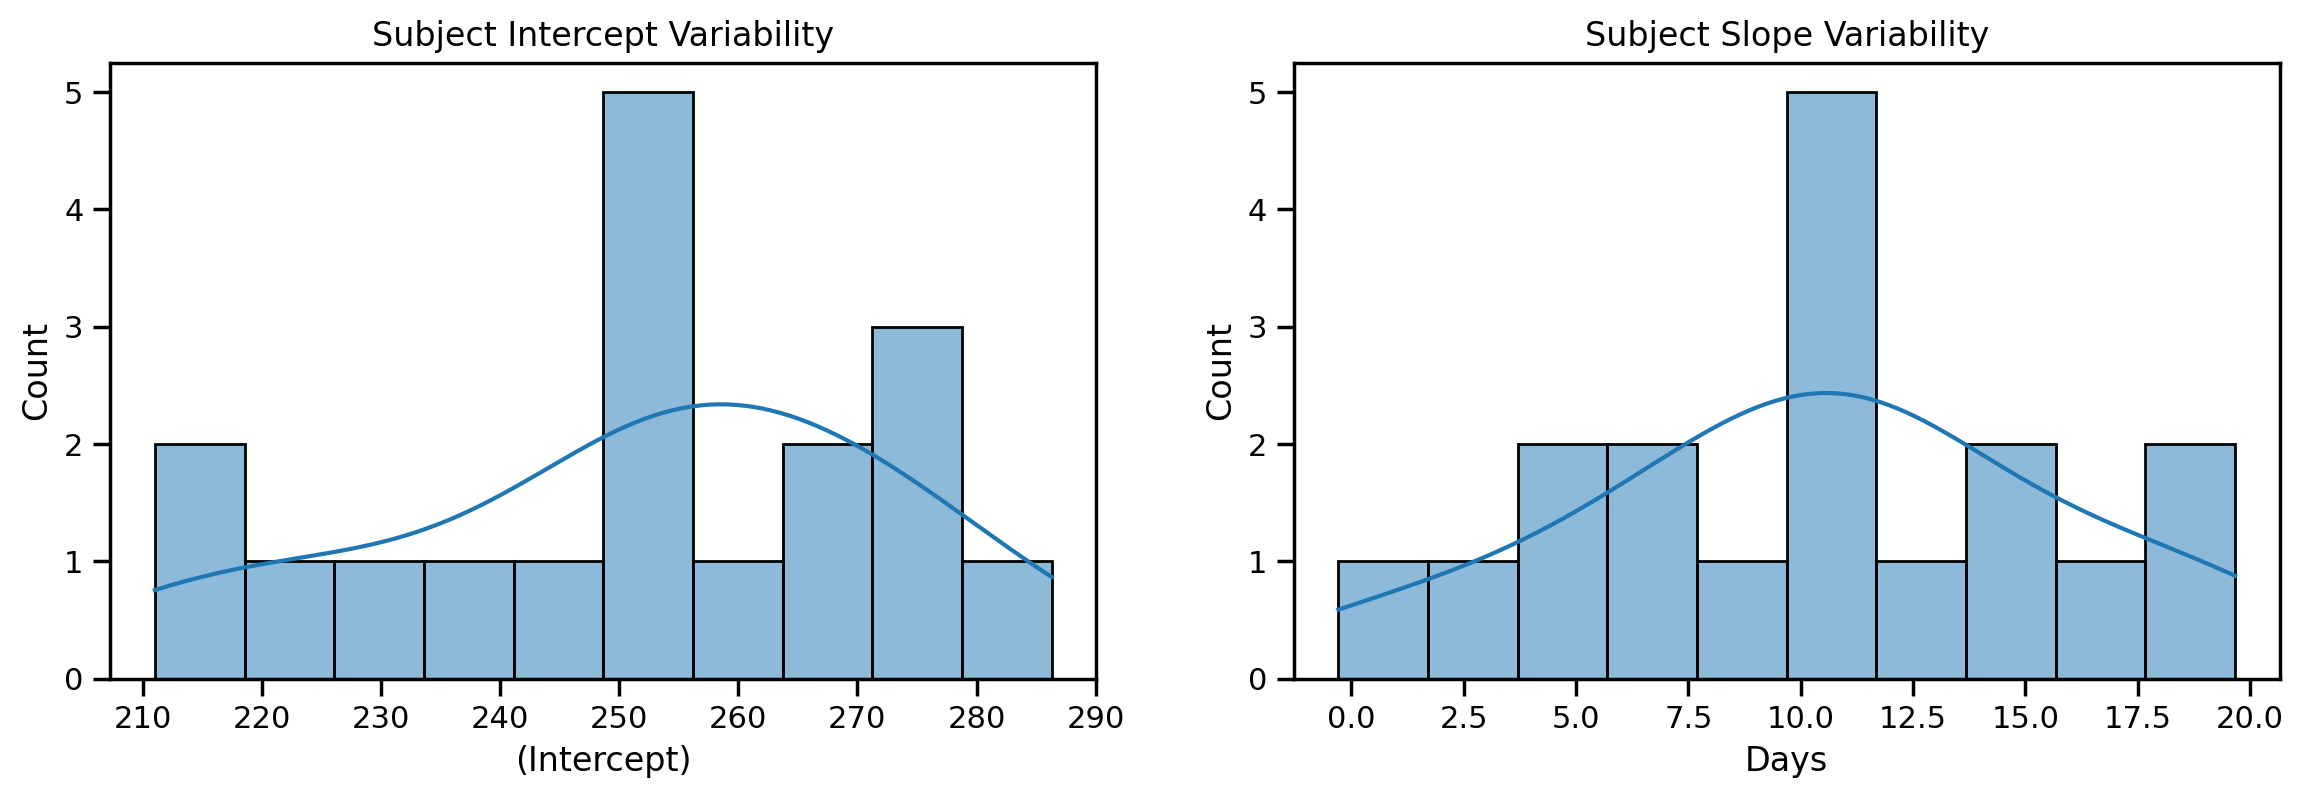

In [6]:
f, axs = plt.subplots(1,2, figsize=(14,4))

# Intercept
ax = sns.histplot(model_is.fixef['(Intercept)'], kde=True, bins=10, ax=axs[0])
ax.set_title('Subject Intercept Variability')

# Slope
ax = sns.histplot(model_is.fixef['Days'], kde=True, bins=10, ax=axs[1])
ax.set_title('Subject Slope Variability');

Let's say we didn't take the varibility of `Days` across people into account. What would happen to our statistical inferences?  
Remember we learned that our **Type I** error-rate would increase! We would be **more** likely to report a **false positive result**

We can see how ignoring this variability puts us in this situation by comparing the *standard error* of our fixed effects between models with and without a random slope. Notice how for the first model (random intercept only) the estimated SE for `Days` is about 0.80 which results a t-statistic of nearly 13.02. That's *huge* t-stat with commensurately tiny p-value!


In [7]:
model_i.coefs

Estimate      2.5_ci     97.5_ci        SE          DF  \
(Intercept)  251.405105  232.301892  270.508318  9.746716   22.810199   
Days          10.467286    8.891041   12.043531  0.804221  161.000000   

                T-stat         P-val  Sig  
(Intercept)  25.793826  2.241351e-18  ***  
Days         13.015428  6.412601e-27  ***

Now look at the SE for `Days` in the model with both random intercepts & random slopes. See how it's nearly **2x larger**? This results in a t-statistic that almost *half* our previous one 13.02 -> 6.77!

In [8]:
model_is.coefs

Estimate      2.5_ci     97.5_ci        SE         DF  \
(Intercept)  251.405105  238.029141  264.781069  6.824597  16.999726   
Days          10.467286    7.437594   13.496978  1.545790  16.999984   

                T-stat         P-val  Sig  
(Intercept)  36.838090  1.171558e-17  ***  
Days          6.771481  3.263824e-06  ***

Because there's a real effect in these data, our estimated coefficent doesn't really change (10.467). But, by asking our model to incorporate the variability across how sleep deprivation affects each person differently, *we become a little more **uncertain** of our estimate*, and a therefore *a little more cautious* before we reject the null hypothesis.

<div style="text-align:center";>
<img src="./figs/inference.png" style="width:400px;">
</div>

### So how do I decide?

In summary we recommend the following approach:
1. Always start with the maximal model you can estimate
2. If you see warnings or errors when calling `.fit()` simplify by removing random-effects
  - Start with correlation between intercept and slope (see formula table from `01_lmms` or below)
  - Then remove slopes
  - Lastly consider removing intercepts
3. Always examine the variability across your clusters using `.ranef`or visually
4. Use `lrt()` to perform model comparison
5. Finally once you've decided on the your random effects, then *and only then* interpret the inferences on your fixef effects (`.coef`)


### Challenge

Use the formula syntax examples below to estimate an LMM with **uncorrelated** intercepts and slopes. 

Compare it to `model_is` which includes intercepts, slopes, and their correlation. What do you notice?

*Your response here*

In [9]:
# Solution
model_is_nocorr = Lmer('Reaction ~ Days + (1 | Subject) + (0 + Days | Subject)', data=df.to_pandas())
model_is_nocorr.fit()

lrt(model_is, model_is_nocorr)

refitting model(s) with ML (instead of REML)


model  npar          AIC          BIC  \
0  Reaction~Days+(1|Subject)+(0+Days|Subject)     5  1762.003255  1777.968039   
1              Reaction~Days+(1+Days|Subject)     6  1763.939344  1783.097086   

   log-likelihood     deviance     Chisq   Df     P-val Sig  
0     -876.001628  1752.003255                               
1     -875.969672  1751.939344  0.063911  1.0  0.800418

## Better understanding the output

Let's take a look at the summary that `Lmer()` models give us. We can get this in one of two ways:
- By passing `summarize = True` to `.fit()`
- Using the `.summary()` method anytime *after* you've used `.fit()` 

The first part of the summary tells us some basic information about the model, our data, and how `Lmer()` interpreted and estimated the random-effects we asked for, including:
  - the number of observations (180)
  - the number of clusters (Groups) 18
  - Log-likelihood & AIC - statistics that reflect the overall fit of the model and let us compare it to other models
  - the variance-covariance of our random-effects (intercept, slope, and their correlation)
  - the fixed effects which looks similar to the output when we summarize an `ols` model

Remember we interpret these estimates the *same way* we would for standard GLM models: the unit change in Y for each unit change in X, assuming all other predictors in the model = 0

In [10]:
model_is.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: Reaction~Days+(1+Days|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 180	 Groups: {'Subject': 18.0}

Log-likelihood: -871.814 	 AIC: 1755.628

Random effects:

                 Name      Var     Std
Subject   (Intercept)  612.100  24.741
Subject          Days   35.072   5.922
Residual               654.940  25.592

                 IV1   IV2   Corr
Subject  (Intercept)  Days  0.066

Fixed effects:



Estimate   2.5_ci  97.5_ci     SE    DF  T-stat  P-val  Sig
(Intercept)   251.405  238.029  264.781  6.825  17.0  36.838    0.0  ***
Days           10.467    7.438   13.497  1.546  17.0   6.771    0.0  ***

If we look at the output of our model with only random intercepts we can see that the slope and correlation are missing the in Random Effects of the summary:

In [11]:
model_i.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: Reaction~Days+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 180	 Groups: {'Subject': 18.0}

Log-likelihood: -893.233 	 AIC: 1794.465

Random effects:

                 Name       Var     Std
Subject   (Intercept)  1378.179  37.124
Residual                960.457  30.991

No random effect correlations specified

Fixed effects:



Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)   251.405  232.302  270.508  9.747   22.81  25.794    0.0  ***
Days           10.467    8.891   12.044  0.804  161.00  13.015    0.0  ***

A topic of some debate in the LMM literature is how to best calculate *p-values*. There reason for this is because the `lme4` R package (upon which `pymer4` is based) **does not include p-values by default**

Remember we can always using *model comparison* with and without fixed effects terms to achieve a similar inference. 
- For `Lmer()` models we do this with the `lrt()` function, not only to compare random-effects but also fixed effects.  
- For `ols()` models we do this using the `anova_lm()` function and we only have fixed effects in these types of models.

A popular alternative that controls false postive rates well is using Satterthwaite or Kenward-Roger approximation to calculate degrees-of-freedom that account for the dependent structure of our model. These allow us to perform **parametric inference** just like we're familiar with:
- Estimate t-stat using ratio of coefficient to standard-error and use degrees-of-freedom to look up p-value assuming a t-distribution

This is the approach that `Lmer()` automatically performs for you and includes in the summary output using the popular `lmerTest` package. However, this is a semi-controversial issue in the literature so we'll leave you with the core help page in R with recommendations:

- [Why doesn't `lme4` display dof or p-values?](https://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#why-doesnt-lme4-display-denominator-degrees-of-freedomp-values-what-other-options-do-i-have)
- [Getting p-values for fitted models](https://rdrr.io/cran/lme4/man/pvalues.html) (screenshot below)

<div style="text-align:center";>
<img src="./figs/pvals.png" style="width:1000px;">
</div>

## Categorical Predictor with 2-levels (paired t-test)

Just like with `ols()` models we can also using **categorical predictors** in `Lmer()` models. 

Let's load some simulated data from 20 participants who provided responses to 2 conditions that we want to compare. This is **repeated measures design** because every participant responded to *both* conditions.

Let's load the data and visualize each participant in a different color:

In [12]:
df2 = pl.read_csv('data/2levels.csv')
df2.head()

shape: (5, 3)
┌─────────────┬───────────┬───────────┐
│ participant ┆ condition ┆ value     │
│ ---         ┆ ---       ┆ ---       │
│ i64         ┆ str       ┆ f64       │
╞═════════════╪═══════════╪═══════════╡
│ 1           ┆ A         ┆ 1.624345  │
│ 2           ┆ A         ┆ -0.611756 │
│ 3           ┆ A         ┆ -0.528172 │
│ 4           ┆ A         ┆ -1.072969 │
│ 5           ┆ A         ┆ 0.865408  │
└─────────────┴───────────┴───────────┘

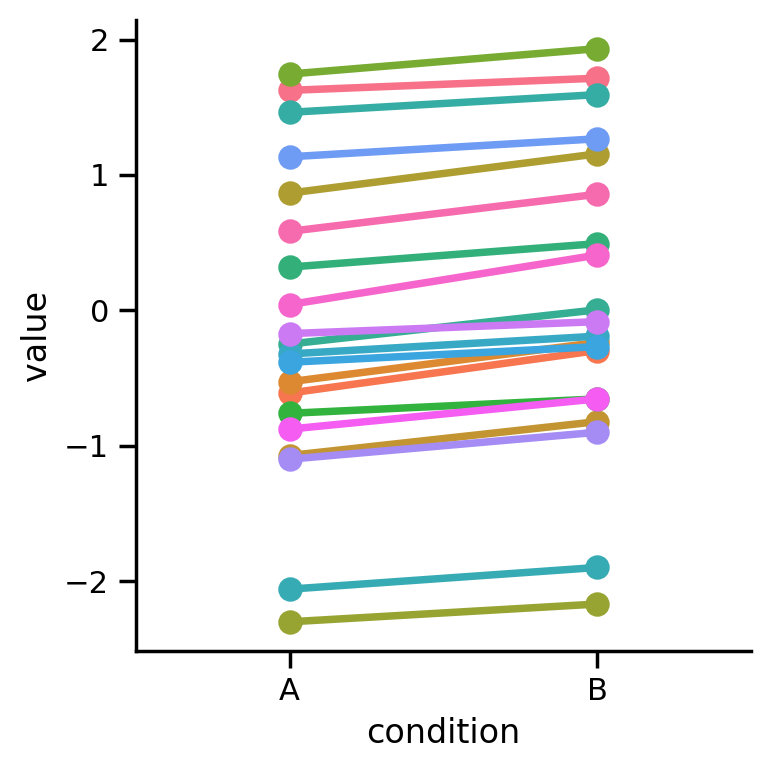

In [13]:
order = ['A', 'B']
grid = sns.FacetGrid(data=df2.to_pandas(), hue='participant', height=4)
grid.map(sns.lineplot, 'condition', 'value')
grid.map(sns.pointplot, 'condition', 'value', order=order);

We can see that difference between conditions is *small* but *consistent* across all our participants. We can use seaborn to visualize the means of each condition and calculate 95% CIs that either **ignore** the dependence in the data or **include** the dependence in the data.

If we include the dependence our CIs are wider on average (orange wider than blue). This is consistent with the increase of the standard-error we saw earlier. We're *a little more uncertain* about our estimate when we take into account the dependency.

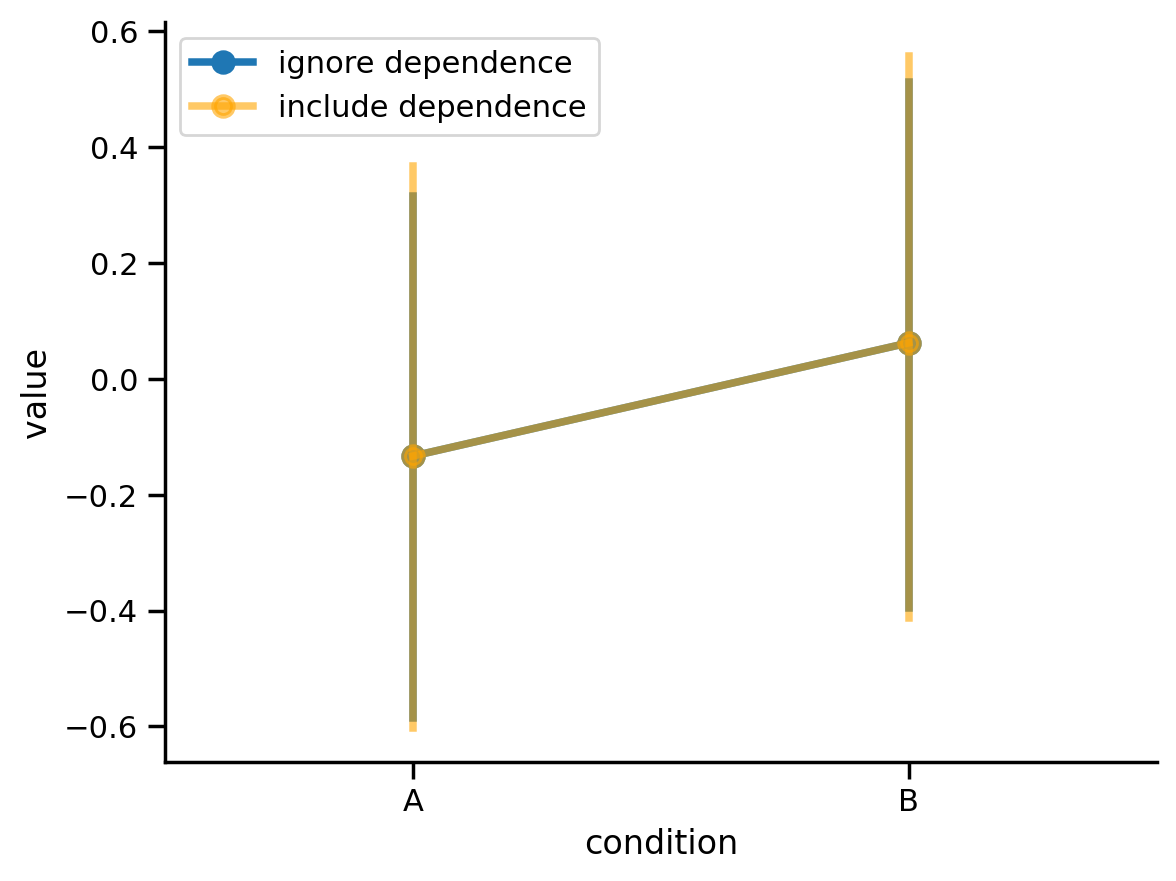

In [14]:
sns.pointplot(x='condition', y='value', data=df2.to_pandas(), label='ignore dependence', seed=1)
sns.pointplot(x='condition', y='value', units='participant', color='orange', alpha=.6, data=df2.to_pandas(), label='include dependence', seed=0)
sns.despine();

However, ignoring dependency doesn't always mean a Type I error (false positive). Sometimes it means a **Type II error (false negative)**

In this case even though the effect is small, it's *consistent* across every single person. 

Let's see what happens if we fit a regular 'ol `ols()` aka use **complete pooling**. Remember to specificy a categorical variable in an `ols()` model we wrap it in `C()`

In [15]:
from statsmodels.formula.api import ols
lm = ols('value ~ C(condition)', data=df2.to_pandas()).fit()
print(lm.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.018
No. Observations:                  40   F-statistic:                    0.3002
Covariance Type:            nonrobust   Prob (F-statistic):              0.587
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1334      0.252     -0.529      0.600      -0.644       0.377
C(condition)[T.B]     0.1954      0.357      0.548      0.587      -0.527       0.917

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


We can see that this difference is not statistically significant and that our standard-error is quite large (0.357) producing a small t-statistic (0.548)

This analysis assumes that each condition was experience by *entirely independent groups of participants*.

In fact it's exactly the same as an independent-samples t-test:

In [16]:
# t-test function from scipy
from scipy.stats import ttest_ind

# values in condition A
condA = df2.filter(col('condition') == 'A')['value'].to_numpy()

# values in condition B
condB = df2.filter(col('condition') == 'B')['value'].to_numpy()

t, pval = ttest_ind(condB, condA)
print(f"t = {t:.3f}, p = {pval:.4f}")

t = 0.548, p = 0.5869


Let's see what happens when we fit an LMM to account for the dependency between conditions, which we can do by adding a **random intercept** per participant.  
Specifying categorical variables in `Lmer()` models **uses different syntax** from `ols()`

For `Lmer()` models, we don't use `C()` in the model formula.  
Instead we use the `factors={}` argument to `.fit()` and provide it a dictionary (`{}`) of contrasts. 
- The key of the dictionary is the name of each of our categorical variables `'condition'` in this case   
- The value of the dictionary is list of the levels of our categorical variable, with the first level being set as the reference level. 
- This is equivalent to the default contrasts that `C()` creates in `ols()` models: **dummy/treatment coding** 

In the code below since condition A comes first, it will be used as the model intercept and the parameter estimate reflects the difference between condition B - condition A

*For additional details you can check out the [tutorial on the pymer4 website](https://eshinjolly.com/pymer4/auto_examples/example_02_categorical.html#lmer-models)*

In [17]:
lmm = Lmer('value ~ condition + (1 | participant)', data=df2.to_pandas())

lmm.fit(factors={
    'condition': ['A', 'B'] # A will be intercept and parameter is B-A
})

If we inspect the summary, we can see the effect is now significant! Why? Take a look at our standard-error...

Beause the effect is *consistent* across every participant, it **reduces our uncertainty** and the LMM explicitly models that!  
This gives us the correct error calculation, increases our power, and reduces our false negative rate.

In [18]:
lmm.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: value~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 40	 Groups: {'participant': 20.0}

Log-likelihood: -11.797 	 AIC: 31.593

Random effects:

                    Name    Var    Std
participant  (Intercept)  1.269  1.126
Residual                  0.003  0.058

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    -0.133  -0.628    0.361  0.252  19.051  -0.529  0.603     
condition1      0.195   0.159    0.232  0.018  19.000  10.586  0.000  ***

In fact this is the LMM equivalent of a *paired-samples* t-test:

In [19]:
from scipy.stats import ttest_rel

t, pval = ttest_rel(condB, condA)
print(f"t = {t:.3f}, p = {pval:.4f}")

t = 10.586, p = 0.0000


## Categorical Predictor with 3+ levels (rm-ANOVA)

Let's look at one more example this time using a categorical predictor with 3 levels. Like before these data come from a *repeated measures design*, where each of 12 participants provided a response to every condition:  

3 *replicates* (observations) per *cluster* (subject) in LMM lingo

Let's visualize the data like before and compare what happens when we estimate a standard `ols()` model (ignoring dependence) and `Lmer()` that explicitly models it

In [20]:
df3 = pl.read_csv('data/3levels.csv')

Visually, the effect isn't as consistent across people as our previous 2-level example data but it does look like there's a slight downward trend from condition A -> C

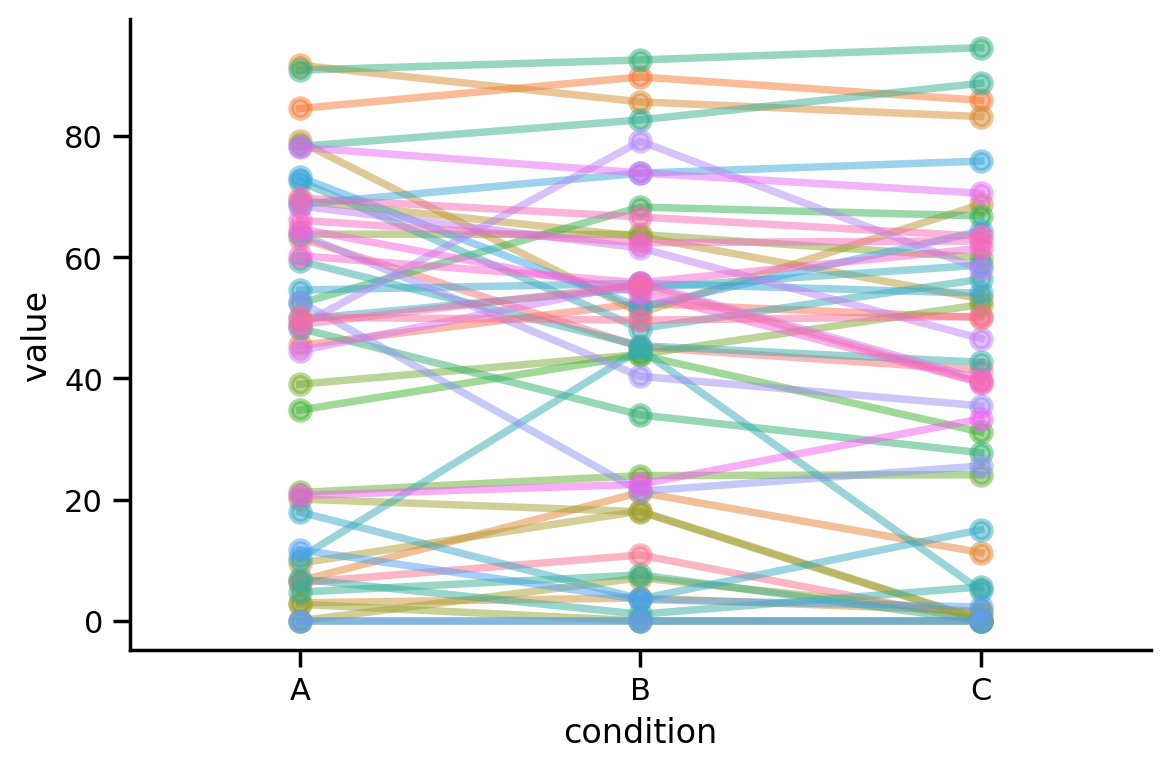

In [21]:
order = ['A', 'B', 'C']
grid = sns.FacetGrid(data=df3.to_pandas(), hue='participant', height=4, aspect=1.5)
grid.map(sns.pointplot, 'condition', 'value', order=order, errorbar=None, alpha=0.5);

We can see this reflected in the means, but we don't know if this is meaningful in light of our uncertainty:

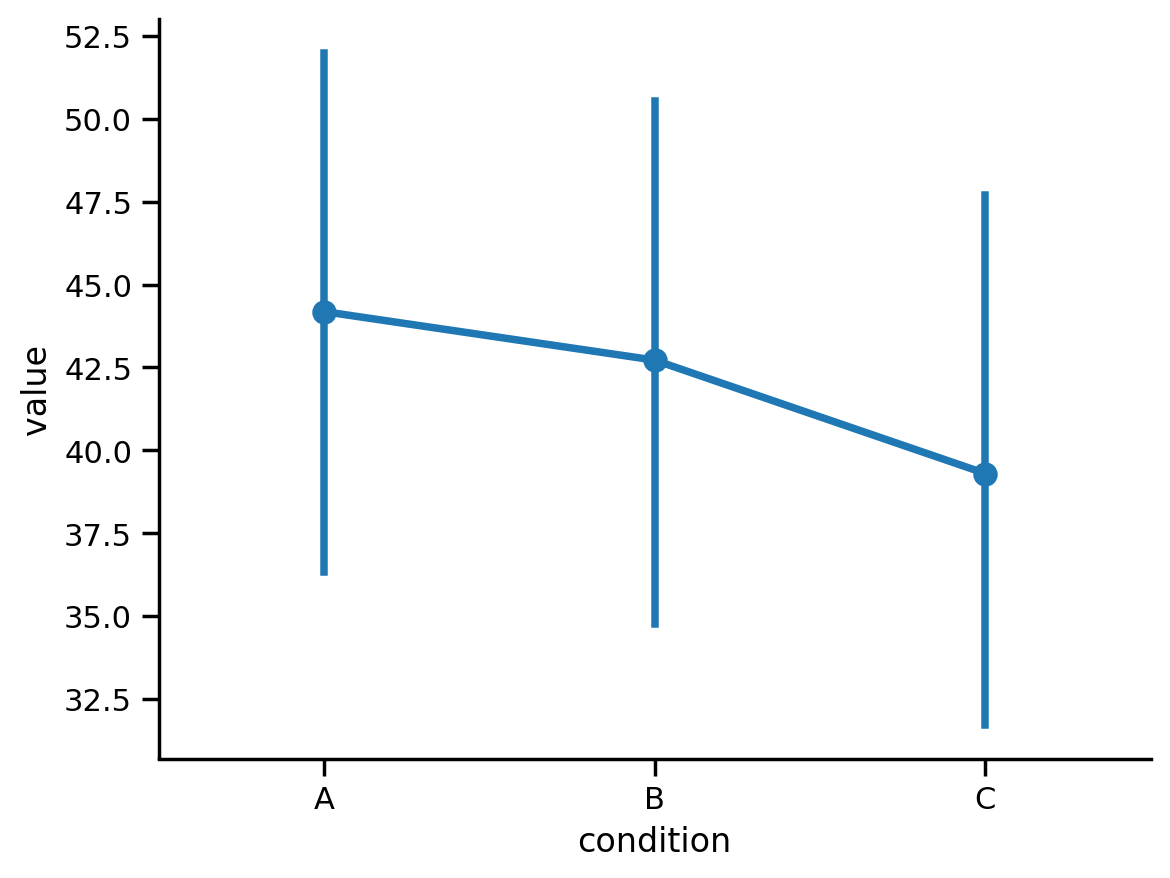

In [22]:
order = ['A', 'B', 'C']
sns.pointplot(x='condition', y='value', order=order, units='participant', data=df3.to_pandas())
sns.despine();

Let's use `ols()` to run a one-way ANOVA, ignoring the dependency.

Remember it's good practice to use an *orthogonal* coding scheme for valid ANOVA tests. 

We can do that using `C(variable, Sum)` or `C(variable, Poly)` to use **deviation/sum** or **polynomial** coding respectively. Both schemes will produce valid ANOVA results, especially in the face of unbalanced data.  

We also want to remember to tell the `anova_lm()` function to use type III sum-of-squares calculations:

In [23]:
from statsmodels.stats.anova import anova_lm

# Orthogonal polynomial contrasts
lm = ols('value ~ C(condition, Poly)', data=df3.to_pandas()).fit()

# Type 3 SS
anova_lm(lm, typ=3).round(4)

sum_sq     df          F  PR(>F)
Intercept           998181.7083    1.0  1064.5161  0.0000
C(condition, Poly)    2359.7781    2.0     1.2583  0.2849
Residual            526041.7985  561.0        NaN     NaN

We can see that this result is not significant. Now let's try estimating an LMM that explicitly models this dependency.
We'll do this again by using **random intercepts** per participants and use `factors` to specific `condition` as a categorical variable.  

To perform an F-test we can use the `.anova()` method which will calculate type III sum-of-squares for us. We will need to ensure we're using an orthogonal coding scheme for valid F-tests, but `Lmer()` offers us 2 ways to do so:
1. Use the `ordered = True` argument to `.fit()` after you specify your `factors`
2. Specify whatever you want for `factors` and pass the `force_orthogonal=True` argument to `.anova()`

Both approaches will use the same strategy as `C(variable, Poly)` by estimating polynomial contrasts that are orthogonal

In [24]:
# Setup model
lmm = Lmer('value ~ condition + (1 | participant)', data=df3.to_pandas())

# Categorical variables
lmm.fit(factors={
    'condition': ['A', 'B', 'C'],
    }, ordered=True) # add ordered = True to ensure orthogonal coding

# Calculate main-effect
lmm.anova()

# Alternatively - but same result
# lmm.anova(force_orthogonal=True)

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


SS           MS  NumDF     DenomDF    F-stat     P-val Sig
condition  2359.778135  1179.889067      2  515.000001  5.296284  0.005287  **

Accounting for the dependence means makes our result significant!  
We can see how by inspecting the coefficients and their uncertainties like before.  
Compared to the output of our `ols()` model our standard errors are again *smaller* thus resulting in *less uncertainty* about our estimates:

In [25]:
print(lm.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
No. Observations:                 564   F-statistic:                     1.258
Covariance Type:            nonrobust   Prob (F-statistic):              0.285
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       42.0693      1.289     32.627      0.000      39.537      44.602
C(condition, Poly).Linear       -3.4518      2.233     -1.546      0.123      -7.838       0.935
C(condition, Poly).Quadratic    -0.7984      2.233     -0.357      0.721      -5.185       3.588

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


Remember because we've used a polynomial coding scheme the first parameter below `condition1` represents a *linear* trend across conditions and the second parameter `condition2` represents a *quadratic* trend across conditions

We can interpret these the same as the `C(condition, Poly).Linear` and `C(condition.Poly).Quadratic` that we see in the `ols` output above

In [26]:
lmm.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: value~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 564	 Groups: {'participant': 47.0}

Log-likelihood: -2405.782 	 AIC: 4821.564

Random effects:

                    Name      Var     Std
participant  (Intercept)  726.565  26.955
Residual                  222.777  14.926

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val  Sig
(Intercept)    42.069  34.265   49.873  3.982   46.0  10.566  0.000  ***
condition1     -3.452  -5.585   -1.318  1.089  515.0  -3.171  0.002   **
condition2     -0.798  -2.932    1.335  1.089  515.0  -0.733  0.464

### Post-hoc comparisons
Our LMM summary suggests that there's a linear trend across conditions. Which conditions?  
We can perform follow-up post-hoc comparisons like we learned about for `ols()` models using the `marginaleffects` package.  

For `Lmer()` models **the syntax is different** and a bit easier to work with: we just use the `.post_hoc()` method and pass in the name(s) of the `marginal_vars` we want to calcualte ANOVA-style cell-means and comparisons for.

We can also use the `p_adjust` argument to correct for multiple comparisons.  

Let's look at the means and comparisons between each `condition` and adjust for multiple comparisons using FDR.

*Note `Lmer()` also supports more complicated categorical designs (e.g. two-way ANOVA, ANCOVA). You can control post-hoc tests for these designs by passing in additional `marginal_vars` or by using `grouping_vars`. [See the pymer4 website for more details and examples](https://eshinjolly.com/pymer4/auto_examples/example_03_posthoc.html#sphx-glr-auto-examples-example-03-posthoc-py)*

In [27]:
# Calculate means for each level of 'condition' and compare them pair-wise with fdr correction
means, comparisons = lmm.post_hoc(marginal_vars='condition', p_adjust='fdr')

P-values adjusted by fdr method for 3 comparisons


In [28]:
means

condition  Estimate  2.5_ci  97.5_ci    SE      DF
1         A    44.184  35.993   52.376  4.08  50.687
2         B    42.721  34.530   50.913  4.08  50.687
3         C    39.303  31.111   47.494  4.08  50.687

Our pairwise comparisons show us that the difference between condition A and the other 2 conditions seems to be the driving factor in our omnibus F-test

In [29]:
comparisons

Contrast  Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
1    A - B     1.463  -2.235    5.160  1.539  515.0   0.950  0.342    
2    A - C     4.882   1.184    8.579  1.539  515.0   3.171  0.005  **
3    B - C     3.419  -0.279    7.116  1.539  515.0   2.221  0.040   *

### Interpreting categorical random-effects

Let's wrap up by exploring how LMMs handle categorical **random-effects**  
In short: they use the **same encoding** for fixed and random effects.  

Let's see his by estimating **random slopes** across condition for each of our participants:

In [30]:
# Setup model
lmm_with_slopes = Lmer('value ~ condition + (condition | participant)', data=df3.to_pandas())

# Categorical variables
lmm_with_slopes.fit(factors={
    'condition': ['A', 'B', 'C'],
    }, ordered=True) # add ordered = True to ensure orthogonal coding


boundary (singular) fit: see help('isSingular') 



Let's ignore that warning for now. We know that for our fixed effects the polynomial coding scheme will estimate a linear trend and a quadratic trend, which is what `condition1` and `condition2` below reflect. Remember in a regression a categorical variable with $k$ levels can be represented by at most $k-1$ parameters:

In [31]:
lmm_with_slopes.coefs

Estimate     2.5_ci    97.5_ci        SE         DF     T-stat  \
(Intercept)  42.069297  34.265359  49.873235  3.981674  46.000579  10.565731   
condition1   -3.451753  -5.738321  -1.165184  1.166638  71.828798  -2.958717   
condition2   -0.798383  -3.269860   1.673093  1.260980  53.101022  -0.633145   

                    P-val  Sig  
(Intercept)  6.868238e-14  ***  
condition1   4.180848e-03   **  
condition2   5.293566e-01

If we look at the participant *deviances* from these fixed effects we can see how **every participant** also has $k-1$ parameters for their random slope:

In [32]:
lmm_with_slopes.ranef.head()

X.Intercept.  conditionB  conditionC
1    -36.743843    3.264310    0.340206
2     11.183791   -6.798232   -3.730456
3      5.263121    3.108404    2.185633
4     42.317753    1.057173    2.617764
5    -31.732664    6.999238    2.905656

If we perform a comparison between models with random intercepts and slopes we can see that in order to estimate random slopes it takes **5 extra parameters** that are not worth it:
- linear trend 
- quadratic trend
- correlation between intercept & linear trend
- correlation between intercept & quadratic trend
- correlation between linea & quadratic trend

In [33]:
lrt(lmm_with_slopes, lmm)

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

refitting model(s) with ML (instead of REML)


model  npar          AIC          BIC  \
0          value~condition+(1|participant)     5  4830.165888  4851.841159   
1  value~condition+(condition|participant)    10  4833.835073  4877.185616   

   log-likelihood     deviance     Chisq   Df     P-val Sig  
0    -2410.082944  4820.165888                               
1    -2406.917537  4813.835073  6.330815  5.0  0.275347

Just 1 random-effect (intercept) per participant: 

In [34]:
lmm.ranef_var

Name         Var        Std
participant  (Intercept)  726.565286  26.954875
Residual                  222.776773  14.925708

3 random effects (intercept & slope) per participant

In [35]:
lmm_with_slopes.ranef_var

Name         Var        Std
participant  (Intercept)  764.410267  27.647970
participant   conditionB   64.110712   8.006917
participant   conditionC   22.491355   4.742505
Residual                  210.893691  14.522179

3 additional correlations between random-effect per participant

In [36]:
lmm_with_slopes.ranef_corr

IV1         IV2      Corr
participant  (Intercept)  conditionB -0.326155
participant  (Intercept)  conditionC -0.074434
participant   conditionB  conditionC  0.966971

### Summary
In general we recommend the same advice when modeling random slopes for categorical predictors:  

**keep it as maximal as you can and use model comparison to select your random-effects structure before interpreting results**

You'll often find that with categorical variables where you only have 1 observation per level per subject, you won't have *enough data* to reliably estimate random slopes. That's what the model is complaining about above with `boundary (singular) fit: see help('isSingular')`

Let's see an even more extreme case when we simply don't have enough data to estimate the random-effects we want at all!

Let's try adding random slopes to our earlier model that used a 2-level categorical predictor. We'll see how it produces an error, but highlights the issue: 
we're trying to use 40 data points to estimate 40+ random effects and we just can't do it!

In this case our *random intercepts only* model from above is the **right choice**. Why?  

Because it's the **maximal random-effects we can support with our data and design**

In [37]:
# Intercept & Slope per participant - We can't do it!
lmm = Lmer('value ~ condition + (condition | participant)', data=df2.to_pandas())

lmm.fit(factors={
    'condition': ['A', 'B'] # factor variable: [level1, level2,...]
})

RRuntimeError: Error: number of observations (=40) <= number of random effects (=40) for term (condition | participant); the random-effects parameters and the residual variance (or scale parameter) are probably unidentifiable
